In [1]:
## Load in needed mods
import pandas as pd, numpy as np, os, hypermutatorqtl as hqtl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Set paths to genotype dataframes
gt_path = '../GENOTYPE/H99_prog_gt.csv.gz'
dp_path = '../GENOTYPE/H99_prog_dps.csv.gz'
ad_path = '../GENOTYPE/H99_prog_adps.csv.gz'

## Set paths to confidence intervals for QTL 
## on chromosome 3 and chromosome 11
ch3_95_savepath = '../DATA/H99_chr3.csv.gz'
ch11_95_savepath = '../DATA/H99_chr11.csv.gz'

## Bring in centromere
Centromeres = hqtl.Centromeres

## check work
assert np.max(Centromeres.shape) >= 14, "Missing chromosomes, check hypermutatorqtl.py"

## set mat locus
MAT = hqtl.MAT

## Set paths to phenotype data
pheno_path = '../PHENOTYPE/F1-progeny-info-processed.csv.gz'

## Load in phenotype data
data = pd.read_csv(pheno_path,index_col=0)

## View head
data.head().T

,30,35,47,10,5
F1 Progeny #,30,35,47,10,5
Mutation rate (qualitative),---,---,---,---,---
Mutation rate (quantitative),0,3.09632e-09,3.37894e-09,5.80508e-09,6.6136e-09
Upper confidence interval,0,2.6642e-10,2.5863e-10,9.7708e-10,1.7808e-09
Lower confidence interval,0,7.93921e-09,8.79736e-09,1.32958e-08,1.34964e-08
Transposition frequency,0,0,100,0,20
Rate,0,0.0309632,0.0337894,0.0580508,0.066136
Uci,0,0.0026642,0.0025863,0.0097708,0.017808
Lci,0,0.0793921,0.0879736,0.132958,0.134964


In [3]:
## Load in genotype data
## Genotypes per site
gts = pd.read_csv(gt_path,index_col=0)

## Gather columns from dataframe
cols = gts.columns.tolist()

## Gather samples
samples = cols[:cols.index('Pos')]

## Check work
assert len(samples) == 28, "Missing samples"

## Gather contig names
chrlist = sorted(gts.Contig.unique())

## Check work
assert len(chrlist) >= 14, "Missing chromosomes in genotype data."

## read depth per siet
dps = pd.read_csv(dp_path,index_col=0)

## Allelic read depth ratio
adp = pd.read_csv(ad_path,index_col=0)

## show shape of df, print a few chromosomes, and print some samples
adp.shape, chrlist[:3], samples[:3]

((215411, 37),
 ['Chr_1', 'Chr_10', 'Chr_11'],
 ['prog41_S62', 'prog17_S67', 'prog36_S75'])

In [4]:
## MAke dataframes per sample
sample_dfs = [] 

## Iterate thru samples
for s in samples:
    
    ## Gather sample genotypes
    gt = gts[[s,'Pos','Contig']]
    gt.columns = ['GT','Pos','Contig']
  
    ## gather sample depths per site
    dp = dps[[s,'Pos','Contig']]
    dp.columns = ['DP','Pos','Contig']
    
    ## Gather allelic read depth ratio
    ad = adp[[s,'Pos','Contig']]
    ad.columns = ['AD','Pos','Contig']
   
    ## concatonate into a single datframe and append
    sdf = pd.concat([gt,dp['DP'],ad['AD']],axis=1)
    sdf['Strain'] = s
    sample_dfs.append(sdf)
    
## Check work
assert len(sample_dfs) == len(samples), "Error in loop above, missing samples"

## Show one of the dataframes for a strain
sample_dfs[0].head()

,GT,Pos,Contig,DP,AD,Strain
191,1.0,10536,Chr_1,421.0,0.612827,prog41_S62
192,1.0,10544,Chr_1,404.0,0.613861,prog41_S62
339,0.0,12618,Chr_1,402.0,0.656535,prog41_S62
341,0.0,12640,Chr_1,392.0,0.770408,prog41_S62
377,0.0,21326,Chr_1,332.0,0.570997,prog41_S62


In [5]:
## Load in chromosome 3 QTL CI
ch3_95df = pd.read_csv(ch3_95_savepath,index_col=0)
ch3l,ch3r = ch3_95df.T.values[0]
ch3l,ch3r

(918548.4125, 1120200.5)

In [6]:
## Load in chromosome 11 QTL CI
ch11_95df = pd.read_csv(ch11_95_savepath,index_col=0)
ch11l,ch11r = ch11_95df.T.values[0]
ch11l,ch11r

(987379.1125, 1193972.0)

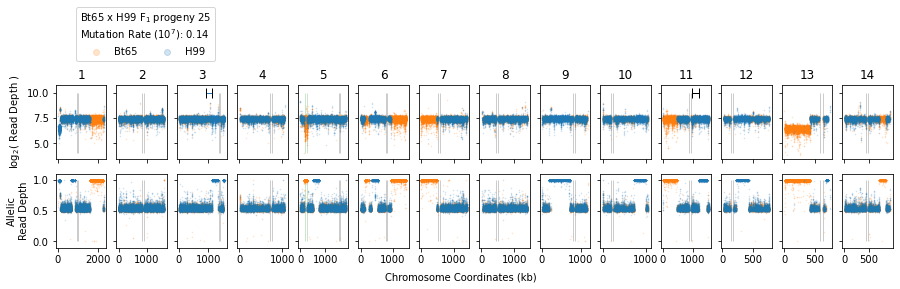

In [7]:
## MAke diagnostic plots for each sample
## Set kb conversion
kb = 1000

## Set ccolors
bt65_color='tab:orange'
h99_color ='tab:blue'

## Iterate the sample dataframes
for i,s in enumerate(sample_dfs):
    
    ## Set dataframe, drop missing values
    sample = samples[i]
    df = s.dropna()
    
    ## Call figure
    fig,ax = plt.subplots(2,14,figsize=(15,3),sharex='col',sharey='row')
    
    ## round mutation rate
    sample_pn = str(sample.split('prog')[-1].split('_')[0])
    r = np.round(data.T[sample_pn]['Rate'],2)

    ## Iterate over chromosome list
    for c in chrlist:
        
        ## Gather genotype datarame 
        bt65 = df[(df.GT==1) & (df.Contig==c)]
        H99 = df[(df.GT==0) & (df.Contig==c)]
        
        ## gather chromosome integer
        cint = int(c.split('_')[-1])-1
        
        ## Gather centromere
        centro = Centromeres.T[cint].values/kb
        
        ## Set axis
        plt.sca(ax[0,cint])
        
        ## plot genotypes
        plt.plot(bt65.Pos.values/kb,np.log2(bt65.DP.values),'.',
                 ms=1,color=bt65_color,
                 alpha=0.2,label='Bt65' if cint == 0 else None,
                 rasterized=True)
        plt.plot(H99.Pos.values/kb,np.log2(H99.DP.values),'.',
                 ms=1,color=h99_color,
                 alpha=0.2,label='H99' if cint == 0 else None,
                 rasterized=True)
        
        ## PLot centromere
        plt.vlines(centro,4,10,linewidth=1,color='k',alpha=0.2)
        
        ## Set title and ylable
        plt.title(str(cint+1))
        plt.ylabel('log$_{2}$( Read Depth )' if cint == 0 else None)
        
        ## Plot chromosome CI and MAT locus based on chromosome
        if cint == 2: ## Chromosome 3, QTL
            plt.hlines(10,ch3l/kb,ch3r/kb,linewidth=1);
            plt.vlines(np.array([ch3l/kb,ch3r/kb]),
                       9.5,10.5,linewidth=1,color='k')
        
        if cint == 10: ## Chromosome 11, QTL
            plt.hlines(10,ch11l/kb,ch11r/kb,
                       linewidth=1,color='k')
            plt.vlines(np.array([ch11l/kb,ch11r/kb]),
                       9.5,10.5,linewidth=1,color='k')
        
        if cint == 4: ## Chromosome 5, the MAT locus is located here in C. neoformans
            plt.vlines(MAT/kb,4,10,linewidth=1,color='g',alpha=0.2)
        
        ## Add legend
        if cint == 0: ## if this is chromosome 1
            leg =plt.legend(bbox_to_anchor=(0.3,1.25),markerscale=10,ncol=2,
                       title='Bt65 x H99 F$_1$ progeny %s\nMutation Rate (10$^7$): %s'%(sample_pn,r))
            
            ## Reset alpha
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
            
            leg.legendHandles[0]._legmarker.set_markersize(12)
            leg.legendHandles[1]._legmarker.set_markersize(12)
        
        ## Set axis and y label
        plt.sca(ax[1,cint])
        plt.ylabel('Allelic\nRead Depth' if cint==0 else None)

        ## Plot allelic read depth ratios
        plt.plot(bt65.Pos.values/kb,bt65.AD.values,'.',ms=1,
                 color=bt65_color,alpha=0.2,rasterized=True)
        plt.plot(H99.Pos.values/kb,H99.AD.values,'.',ms=1,
                 color=h99_color,alpha=0.2,rasterized=True)
        
        ## Aadd centromere
        plt.vlines(centro,0,1,linewidth=1,color='k',alpha=0.2)
        
        ## plot mat locus
        if cint == 4: ## Chromosome 5, the MAT locus is located here in C. neoformans
            plt.vlines(MAT/kb,0,1,linewidth=1,color='g',alpha=0.2)

        ## Set ylimit
        plt.ylim(-0.1,1.1);
        
    ## Add figure x-axis test
    fig.text(0.5,-0.01,'Chromosome Coordinates (kb)',va='center',ha='center')
    
    ## Save figure and close
    plt.savefig('../FIGURES/PROGENY/Figure_S13_progeny_%s.pdf'%sample_pn,
                dpi=300,bbox_inches='tight');
    
    if sample_pn != '25':
        plt.close()